# Development 

## Image to Value(s)

### Primary Focus: Explainable Object Counting in Microscopy Images
### Application: Explainable Virus Capsid Quantification
#### Challenge: Deep Learning as Black Box
#### Required Labels: Location Labels


TL;DR 🧬✨ We developed a regression model to quantify maturation states ("naked", "budding", "enveloped") of human cytomegalovirus (HCMV) during its final envelopment process i.e. secondary envelopment. Researchers can adapt the provided notebook for their own EM data analysis. 

![Teaser](./images/Teaser.png)




# Setup and Imports

> *Execute the cell below to import external libraries, which simplify the implementation of the notebook.*

In [1]:
# auto reload imports
%load_ext autoreload
%autoreload 2

# imports from the template 
from deepEM.Utils import create_text_widget, print_info, find_file, create_checkbox_widget
from deepEM.Logger import Logger
from deepEM.ModelTuner import ModelTuner

# costum implementation
from src.ModelTrainer import ModelTrainer


# import all required libraries
from pathlib import Path 
import os



# 1. Data

## 1.1. Data Acquisition
For exemplary purposes, we utilize existing data from [1]. However, we strongly encourage researchers to provide their own datasets tailored to their laboratory's specific needs. This approach enables training models optimized for the lab's unique sample preparation techniques and microscope attributes, such as detector configurations. Providing a different dataset can also address different types of application, like counting of different objects within an EM image.

----
*[1] Shaga Devan, Kavitha, et al. "Improved automatic detection of herpesvirus secondary envelopment stages in electron microscopy by augmenting training data with synthetic labelled images generated by a generative adversarial network." Cellular Microbiology 23.2 (2021): e13280.*

## 1.2. Data Annotation

This notebook requires annotations of object locations along with their corresponding classes.

The example dataset includes annotations for the locations of virus capsids within an image, categorized by their envelopment stages, $C=[’naked’,’budding’,’enveloped’]$.

To adapt the application of this notebook, EM researchers can provide their own dataset. 
In the following, we outline an exemplary workflow for generating annotation labels for the specific task of predicting the number of virus capsids and their corresponding envelopment stages.

For data annotation we recomment using the <a href="https://www.cvat.ai/">CVAT</a> (Computer Vision Annotation Tool) tool. For further instructions, we refer to our <a href="">Getting Started</a> guide.



### 1.2.1. Create a New Task

<p align="center">
  <img src="https://viscom-ulm.github.io/DeepEM/static/images/explainable-virus-quantification/CVAT-1.png" alt="Create New Task1" width="500">
  <br>
</p>
When starting CVAT, you first need to create a new task. You can give it a name, add annotation types and upload your data.

<p align="center">
  <img src="https://viscom-ulm.github.io/DeepEM/static/images/explainable-virus-quantification/CVAT-2.png" alt="Create New Task2" width="500">
  <br>
</p>

Next, click on the `Add label` button. Name it based on the class you want to annotate. In our case one of *"naked", "budding", "enveloped"*. As annotation type choose `Points`. You should also pick a color, as this will simplify the annotation process. For adding new class click `Continue`. Once you added all nessecary classes click `Cancel`. 


<p align="center">
  <img src="https://viscom-ulm.github.io/DeepEM/static/images/explainable-virus-quantification/CVAT-3.png" alt="Create New Task3" width="500">
  <br>
</p>

Now you can upload the data you wish to annotate. Finally, click `Submit & Open` to continue with the annotation of the uploaded data. 

### 1.2.2. Annotation

<p align="center">
  <img src="https://viscom-ulm.github.io/DeepEM/static/images/explainable-virus-quantification/CVAT-4.png" alt="Annotate1" width="500">
  <br>
</p>

This will open following view. Click on the job (in this view the `Job #1150022`) to start the annotation job. 

<p align="center">
  <img src="https://viscom-ulm.github.io/DeepEM/static/images/explainable-virus-quantification/CVAT-5.png" alt="Annotate2" width="500">
  <br>
</p>

To then annotate your data, select the `Draw new points` tool. Select the Label you wish to annotate from the dropdown menue. Then click `Shape` to annotate individual virus capsids with the label class. (Track will allow you to place annotations over multiple frames, which is helpful when annotating videos, tomograms or similar). You can use the arrows on the top middle to navigate through all of your data and to see your annotation progress. 

### 1.2.3. Save Annotation

<p align="center">
  <img src="https://viscom-ulm.github.io/DeepEM/static/images/explainable-virus-quantification/CVAT-6.png" alt="Save1" width="500">
  <br>
</p>

Once you are done annotating data, click on the `Menu` and select `Export job dataset`. 

<p align="center">
  <img src="https://viscom-ulm.github.io/DeepEM/static/images/explainable-virus-quantification/CVAT-7.png" alt="Save2" width="500">
  <br>
</p>

During export select the `CVAT for Images 1.1` format and give the folder a name. It will prepare the dataset for download. If you have the annotated images stored locally, there is no need to enable `Save Images`. 

<p align="center">
  <img src="https://viscom-ulm.github.io/DeepEM/static/images/explainable-virus-quantification/CVAT-8.png" alt="Save3" width="500">
  <br>
</p>

In the horizontal menu bar at the top go to `Requests`. It will show a request Export Annotations. On the right of this request click on the three dots on the right to download your exported, annotated data. This will download a .zip file containing the annotation file in .xml format. The name of the file should be "annotations.xml".



## 1.3. Data Preprocessing

The provided notebook requires all images to be in `.tif` format, containing single 2D images. If this is not the case for your data, you can use the [ImageJ](https://imagej.net/ij/) software. 
ImageJ is an open-source, Java-based image processing software that runs on multiple platforms and offers a wide range of features, including automation with macros, extensive community support, and a large library of tools and plugins.

In the following we showcase an example usecase to import and export data into required formats. 



<p align="center">
  <img src="./images/ImageJ-1.png" alt="ImageJ1" width="500">
  <br>
</p>

This tool allows to `import` a large amount of different, commonly used file formats im EM. 

<p align="center">
  <img src="./images/ImageJ-2.png" alt="ImageJ2" width="500">
  <br>
</p>

Using the provided `Save As..` functionality allows to save the imported files as a `Image Sequence` in .tif format or single `.tif` files.

## 1.4. Data Structuring

The provided notebook requires that all training, validation and testing data is placed within a single folder. Splitting the data into train, test and validation will be done during runtime. 

Additionally, the generated `annotations.xml` should be put in the same folder as the .tif images.

You can check the exemplary data provided at `data/tem-herpes/` for clarification.

An example with five images and the corresponding annotation is shown below: 

```
/data/tem-herpes/
├── image_001.tif
├── image_002.tif
├── image_003.tif
├── image_004.tif
├── image_005.tif
└── annotations.xml

```

> *Execute the cell below to show a text form. Within this text form you need to define the path to your training data (i.e. `data/tem-herpes/`).*


In [2]:
data_widget = create_text_widget("Data Path:","./data/tem-herpes","Enter the path to your data folder.")
display(*data_widget)

Text(value='./data/tem-herpes', description='Data Path:', layout=Layout(width='1000px'), style=TextStyle(descr…

HTML(value='<b>Hint:</b> Enter the path to your data folder.')

> *Execute the cell below to set and check the provided Data Path from the text form above.*

In [3]:
data_path = data_widget[0].value
print(f"[INFO]::Data path was set to: {data_path}")

[INFO]::Data path was set to: ./data/tem-herpes


# 2. Model Training

## 2.1. Setup Logging

By executing the cell below, we setup the logging directory for the hyperparameter search, model training and evaluation. 
The logger creates a folder at `./logs/<datafoldername>-<currentdatetime>/`. 

For each training run there will be one subfolder within the log directory. Training runs of hyperparameter sweeps are called `Sweep_<idx>`, while the subfolder of the final training run is called `TrainingRun`. During evaluation there will be one more subfolder created called `Evaluate`. 

Within each subfolder folder there will be logging of: 

- the used hyperparameters, (`<log-path>/<subfolder>/hyperparameters.json`)
- the best performing model checkpoint based on the validation loss (`<log-path>/<subfolder>/checkpoints/best_model.pth`)
- the last model checkpoint (`<log-path>/<subfolder>/checkpoints/latest_model.pth`)
- visualizations of training and validation curves (`<log-path>/<subfolder>/plots/training_curves.png`)
- qualitative visualization of sampled validation images (`<log-path>/<subfolder>/samples/`)
- results on test metrics (`<log-path>/<subfolder>/test_results.txt`)
- qualitative visualization of sampled test images (`<log-path>/<subfolder>/samples/`)


Sample visualizations of this use case include the model input, validation labels, predictions, and a GradCAM overlay. GradCAM can be interpreted as an heat map, giving an intuition about "where the model looks" to make its prediction.

Visualization of training and validation curves will also be shown after every successful training run within this notebook. They can help to identify possible issues like overfitting during training. For more details, we refer to [this guide](https://www.kaggle.com/code/ryanholbrook/overfitting-and-underfitting).

> *Exectue the cell below to setup the logger. **Hint** If you wish to train a new model, you can reexecute this cell, to generate a new log directory - allowing you to now override the previousely trained model.*


In [4]:
logger = Logger(data_path)

2025-03-27 17:46:20,674 - INFO - Logger initialized. Logs will be saved to: logs/tem-herpes_2025-03-27_17-46-20


## 2.2. Hyperparameter Tuning

Hyperparameters in deep learning control how a model is trained. Unlike learned model parameters, they are set before training. Hyperparameter tuning explores different configurations by training the model multiple times and selecting the best-performing settings based on validation performance. Since this process is time- and resource-intensive, training runs are often limited in duration or dataset size.

Our playground automates hyperparameter search using grid search, testing all possible combinations of selected hyperparameters. The search space is initially defined by deep learning (DL) experts, who also provide explanations so electron microscopy (EM) specialists can refine it as needed. In order to do so, you can adapt the form below. Each sweep hyperparameter should be separated by `,`. Floating point values should be written like `0.1`. 
Logging estimates the remaining time for individual runs and the full sweep, though early estimates may be inaccurate.

While not strictly required, a hyperparameter search should be performed at least once per dataset to ensure optimal model performance. Interrupting the search early may yield suboptimal results. The automatic sweep stores tested configurations and the best-performing parameters in the training data directory under `Sweep_Parameters`, allowing reuse for future training, or to resume the sweep if the kernel got interrupted.


> *Execute the cell below to show the form of the hyperparameter search space. **Hint** If you've changed parameters and want to reset them to the defaults, reexecute the cell.*

In [5]:
# hyperparameter search
model_trainer = ModelTrainer(data_path, logger)

hyperparameter_tuner = ModelTuner(model_trainer, data_path, logger)
form = hyperparameter_tuner.create_hyperparameter_widgets()
display(form)


> *If you wish to run a hyperparameter sweep based on the parameters above, please execute the cell below. This should be done at least once per dataset. Note that this can take a while.*

2025-03-27 17:46:23,135 - INFO - Start hyperparameter sweep...
2025-03-27 17:46:23,136 - INFO - Found sweep log with current best parameters: {'learning_rate': 1e-06, 'batch_size': 16}
2025-03-27 17:46:23,137 - INFO - Logger initialized. Logs will be saved to: logs/tem-herpes_2025-03-27_17-46-20/Sweep_0
2025-03-27 17:46:23,138 - INFO - Start Sweep 1 of 6...
2025-03-27 17:46:23,138 - INFO - Current hyperparams {'learning_rate': 1e-06, 'batch_size': 8}
2025-03-27 17:46:23,139 - INFO - Current sweep configuration {'learning_rate': 1e-06, 'batch_size': 8} already exists at ./data/tem-herpes/Sweep_Parameters/best_sweep_parameters.json. Continue to next configuration.
2025-03-27 17:46:23,139 - INFO - Logger initialized. Logs will be saved to: logs/tem-herpes_2025-03-27_17-46-20/Sweep_1
2025-03-27 17:46:23,140 - INFO - Start Sweep 2 of 6...
2025-03-27 17:46:23,140 - INFO - Current hyperparams {'learning_rate': 1e-06, 'batch_size': 16}
2025-03-27 17:46:23,141 - INFO - Current sweep configurati

Train subset: 0.5


[Training Run] | Num Epochs: 300 | Dataset size: 106: 100%|██████████| 300/300 [13:49<00:00,  2.77s/it]


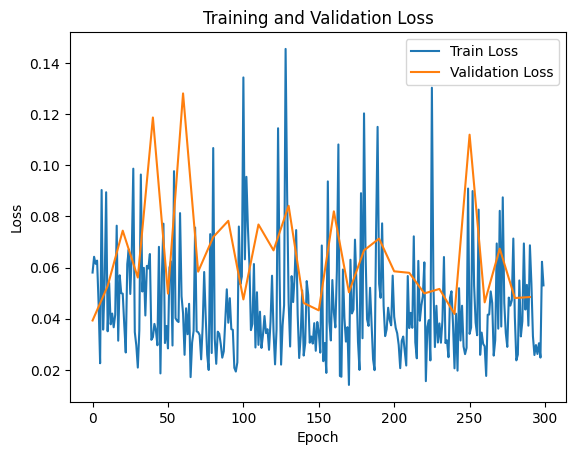

2025-03-27 18:00:16,619 - INFO - Finished training. Find logs and model checkpoints at: logs/tem-herpes_2025-03-27_17-46-20/Sweep_3

2025-03-27 18:00:16,623 - INFO - Hyperparameters: {'learning_rate': 1e-05, 'batch_size': 16}, Validation Loss: 0.03930407850404865
2025-03-27 18:00:16,623 - INFO - Avg time single sweep: 0h3m27s | Remaining_time: 0h6m55s
2025-03-27 18:00:16,624 - INFO - Current best sweep parameters were saved to ./data/tem-herpes/Sweep_Parameters/best_sweep_parameters.json
2025-03-27 18:00:16,625 - INFO - Logger initialized. Logs will be saved to: logs/tem-herpes_2025-03-27_17-46-20/Sweep_4
2025-03-27 18:00:16,625 - INFO - Start Sweep 5 of 6...
2025-03-27 18:00:16,626 - INFO - Current hyperparams {'learning_rate': 0.0001, 'batch_size': 8}
2025-03-27 18:00:16,627 - INFO - Hyperparameters saved to logs/tem-herpes_2025-03-27_17-46-20/Sweep_4/hyperparameters.json


Train subset: 0.5


[Training Run] | Num Epochs: 300 | Dataset size: 106: 100%|██████████| 300/300 [15:14<00:00,  3.05s/it]


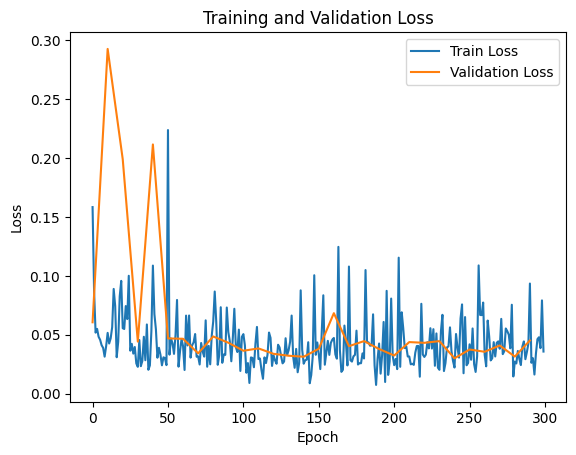

2025-03-27 18:15:33,595 - INFO - Finished training. Find logs and model checkpoints at: logs/tem-herpes_2025-03-27_17-46-20/Sweep_4

2025-03-27 18:15:33,596 - INFO - Hyperparameters: {'learning_rate': 0.0001, 'batch_size': 8}, Validation Loss: 0.030033246822395453
2025-03-27 18:15:33,596 - INFO - Avg time single sweep: 0h5m49s | Remaining_time: 0h5m49s
2025-03-27 18:15:33,598 - INFO - Current best sweep parameters were saved to ./data/tem-herpes/Sweep_Parameters/best_sweep_parameters.json
2025-03-27 18:15:33,599 - INFO - Logger initialized. Logs will be saved to: logs/tem-herpes_2025-03-27_17-46-20/Sweep_5
2025-03-27 18:15:33,599 - INFO - Start Sweep 6 of 6...
2025-03-27 18:15:33,600 - INFO - Current hyperparams {'learning_rate': 0.0001, 'batch_size': 16}
2025-03-27 18:15:33,600 - INFO - Hyperparameters saved to logs/tem-herpes_2025-03-27_17-46-20/Sweep_5/hyperparameters.json


Train subset: 0.5


[Training Run] | Num Epochs: 300 | Dataset size: 106: 100%|██████████| 300/300 [13:48<00:00,  2.76s/it]


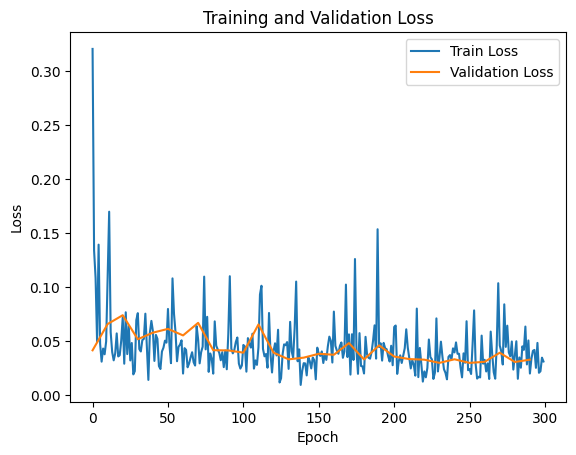

2025-03-27 18:29:23,984 - INFO - Finished training. Find logs and model checkpoints at: logs/tem-herpes_2025-03-27_17-46-20/Sweep_5

2025-03-27 18:29:23,984 - INFO - Hyperparameters: {'learning_rate': 0.0001, 'batch_size': 16}, Validation Loss: 0.029994431225916034
2025-03-27 18:29:23,985 - INFO - Avg time single sweep: 0h7m8s | Remaining_time: 0h0m0s
2025-03-27 18:29:23,985 - INFO - Current best sweep parameters were saved to ./data/tem-herpes/Sweep_Parameters/best_sweep_parameters.json
2025-03-27 18:29:23,986 - INFO - Best Parameters: {'learning_rate': 1e-06, 'batch_size': 16}, Best Loss: 0.04358621825425265, Best Sweep index: 5
2025-03-27 18:29:23,986 - INFO - Finished sweep with best validation loss = 0.04358621825425265.
2025-03-27 18:29:23,986 - INFO - Will use these hyperparameters: {'learning_rate': 1e-06, 'batch_size': 16}


In [6]:
best_config = None
hyperparameter_tuner.update_config(form)
best_config = hyperparameter_tuner.tune()

Our automatic hyperparameter tuning is able to find the best performing set of hyperparameters based on the setting shown above. 

However, there can be scenarios, where additional flexibility is required. Therefore, you are able to change these hyperparameters in the following. 

> *Execute the cell below to show and possibly adapt the currently chosen hyperparameters.*

In [7]:
form = hyperparameter_tuner.edit_hyperparameters()
display(form)

Additionally, you can increase the number of training epochs. An 'epoch' in deep learning is one full pass of the model through all the training data, where the model learns and adjusts to improve its predictions. Higher number of epochs leads to longer training but can further improve model performance.

> *Execute the cell below to show and possibly adapt the number of training epochs. Leave as is, if you want to train with the suggestion of the DL expert.*

In [8]:
epochs_widget = create_text_widget("Epochs:",str(model_trainer.num_epochs),"Higher number of epochs leads to longer training but can further improve model performance.")
display(*epochs_widget)

Text(value='300', description='Epochs:', layout=Layout(width='1000px'), style=TextStyle(description_width='ini…

HTML(value='<b>Hint:</b> Higher number of epochs leads to longer training but can further improve model perfor…

> *Execute the cell below to set the hyperparameters and number of training epochs for your training run, based on the forms above.*

In [9]:
best_config = hyperparameter_tuner.update_hyperparameters(form)
model_trainer.num_epochs = int(epochs_widget[0].value)
print_info(f"Will use following hyperparameters for future training: {best_config} with number of epochs: {model_trainer.num_epochs}.")


[INFO]::Will use following hyperparameters for future training: {'learning_rate': 0.0001, 'batch_size': 16} with number of epochs: 300.


## 2.3. Training and Validation

In this section we train and validate the model based on the provided data and hyperparameters resulting from the previous sweep.

Training in deep learning is the process where a model learns patterns from labeled data (the one provided at the top of this notebook) by optimizing its parameters through backpropagation. 
Validation involves using a separate dataset to evaluate the model's performance during training, ensuring it generalizes well to unseen data.

Training and validating a model can take a lot of time (ranging from minutes to hours, days or even weeks) depending on the model, the training procedure and the dataset. Our logging module provides approximate times for training, which you can see below the executed training cell or at the `log.txt` within the current log directory (i.e. `<log-dir>/TrainingRun/`). However, these times can be inaccurate, especially at the beginning of training. 

### Model Checkpoint
In the following you can provide a model checkpoint for training. There are two different scenarios when you might want to provide a model checkpoint:

1. You wish to resume training. This means, training will picks up exactly where it left off, including learned patterns and settings. This is useful if training was interrupted and needs to be finished from the last saved state. To do so, you need to provide a model checkpoint in the text form below. You can find the last saved checkpoint inside the runs logging directory (`<log-dir>/TrainingRun/checkpoints/latest_model.pth`).
2. If you wish to finetune your model. Fine-tuning starts training from the beginning (epoch 0) but uses a pre-trained model as a starting point, already having knowledge about some previousely learned patterns, to improve its performance on a new task or dataset. You can find the best model checkpoint inside the runs logging directory (`<log-dir>/TrainingRun/checkpoints/best_model.pth`).

If you wish to finetune the model, you need to check the checkbox below. If you only provide the path to a directory, it will look for a `best_model.pth` or `latest_model.pth` accordingly, within this directory.


If you want to start training from scratch (which is usually the case), you can leave the text form below empty.

> *Execute the cell below to show a text form. If you wish to resume training, or do finetuning you need to provide a path to a model checkpoint. Leave it empty for standard training.*

In [10]:
resume_widget = create_text_widget("Model Checkpoint Path:","","If you wish to resume an earlier training, or do finetuning, enter the path to the latest_model.pth or the best_model.pth file here.")
checkbox_widget, description_widget = create_checkbox_widget(
    name="Enable Finetuning",
    value=False,
    description="Check this box to do finetuning based on the provided model checkpoint above. This means, the models weights will be used for initializing the model, training will be then done as usual."
)
display(*resume_widget, checkbox_widget, description_widget)

Text(value='', description='Model Checkpoint Path:', layout=Layout(width='1000px'), style=TextStyle(descriptio…

HTML(value='<b>Hint:</b> If you wish to resume an earlier training, or do finetuning, enter the path to the la…

Checkbox(value=False, description='Enable Finetuning', style=CheckboxStyle(description_width='initial'))

HTML(value='<b>Hint:</b> Check this box to do finetuning based on the provided model checkpoint above. This me…

> *Execute the cell below to prepare the model and data for training.*

In [11]:
resume_training = resume_widget[0].value
finetuning = checkbox_widget.value
if(resume_training):
    if(os.path.isfile(resume_training)):
        logger.log_info(f"Found model checkpoint at {resume_training}.")

    else: 
        if(not finetuning):
            resume_training = find_file(resume_training, "latest_model.pth")           
        else: 
            resume_training = find_file(resume_training, "best_model.pth")
            
            
        if(resume_training is None):
            logger.log_error(f"Could not find resume path at {resume_widget[0].value}. Will start training from scatch.")
        else: 
            logger.log_info(f"Found model checkpoint at {resume_training}.")

else:
    resume_training = None
logger.init("TrainingRun")
model_trainer.resume_from_checkpoint = resume_training
model_trainer.finetuning = finetuning
model_trainer.prepare(best_config)


2025-03-27 18:29:24,158 - INFO - Logger initialized. Logs will be saved to: logs/tem-herpes_2025-03-27_17-46-20/TrainingRun
2025-03-27 18:29:24,159 - INFO - Hyperparameters saved to logs/tem-herpes_2025-03-27_17-46-20/TrainingRun/hyperparameters.json


> *Execute the cell below if you wish to **train** a model. Note that this can take a while.* 

[Training Run] | Num Epochs: 3000 | Dataset size: 212: 100%|██████████| 3000/3000 [2:04:54<00:00,  2.50s/it]  


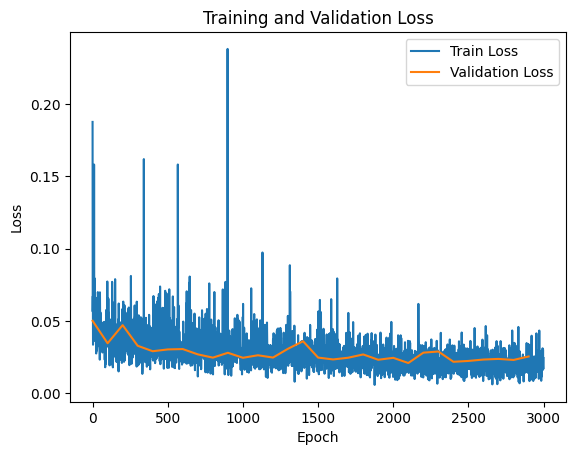

2025-03-27 20:34:21,732 - INFO - Finished training. Find logs and model checkpoints at: logs/tem-herpes_2025-03-27_17-46-20/TrainingRun



np.float64(0.02086351715282591)

In [12]:
model_trainer.fit()

# 3. Model Evaluation
Evaluation in deep learning is the process of evaluating a trained model on a separate, unseen dataset to measure its final performance. It provides an unbiased assessment of the model's ability to generalize to new data.

## 3.1. Choose Model 

In this section we choose the model for testing. 
If you leave the `Model Path` empty in the text form below, it will use the last model trained.
Otherwise, you can define the path to the models best weights at `<log-path>/TrainingRun/checkpoints/best_model.pth` or by providing a path to a directory, which contains `best_model.pth` (like `<log-path>/TrainingRun/`). This allows you to also test shared models or previousely trained models.

> *Execute the cell below to show the text form for selecting a model for testing.*

In [13]:
model_widget = create_text_widget("Model Path:","","If you wish to test a specific model, you can here define the path to its checkpoint. (For example: logs/tem-herpes_2025-02-03_11-42-43/TrainingRun/checkpoints)")
display(*model_widget)

Text(value='', description='Model Path:', layout=Layout(width='1000px'), style=TextStyle(description_width='in…

HTML(value='<b>Hint:</b> If you wish to test a specific model, you can here define the path to its checkpoint.…


You can check the generalizability of your model, or a model you've received from a fellow collegue by testing it on another set of annotated data. In this case, you probably want to use all data within your provided data path for testing. If this is the case, you can check the checkbox below to do so. Note that this should only be done if you didn't train the model on the same data, but you'd like to assess its performance on a different dataset, to test its generalizability.

> *Execute the cell below to show a checkbox. When checking the box, you will evaluate the model on the full data provided at the data directory. Only do this, if you did not train the model on the same data.*

In [14]:
checkbox_widget_test_split, description_widget_test_split = create_checkbox_widget(
    name="Evaluate on full dataset",
    value=False,
    description=f"Check this box to use all the data provided in '{data_path}' for evaluation. Only do this, if you did not train the model on the same data."
)
display(checkbox_widget_test_split, description_widget_test_split)

Checkbox(value=False, description='Evaluate on full dataset', style=CheckboxStyle(description_width='initial')…

HTML(value="<b>Hint:</b> Check this box to use all the data provided in './data/tem-herpes' for evaluation. On…

## 3.2. Evaluate
We finally evaluate the provided model on the test set. We investigate following metrics: 

#### **False Positive (FP)**
- **Definition**: A **false positive** occurs when the model **detects an object that is not actually there**.  
- **Example**: Imagine an electron microscopy image where the model highlights a structure as a capsid, but in reality, it is just noise. This would be a **false positive** because the detection is incorrect.  
- **Explanation**: The **FP value** represents the **average number of incorrectly detected objects** per image patch—cases where the model mistakenly finds objects that do not exist.  

---

#### **False Negative (FN)**
- **Definition**: A **false negative** occurs when the model **fails to detect an actual object** that is present in the image.  
- **Example**: Suppose there is a capsid in the image, but the model **does not recognize it**. This is a **false negative** because an actual object was missed.  
- **Explanation**: The **FN value** represents the **average number of real objects that the model failed to detect** per image patch.  

---

#### **True Positive (TP)**
- **Definition**: A **true positive** occurs when the model correctly detects an object that is actually present.  
- **Example**: If there is a capsid in the image and the model correctly detects it, this is a **true positive**.  
- **Explanation**: The **TP value** represents the **average number of correctly detected objects** per image patch—cases where the model successfully identifies real objects.  

---

#### **Mean Absolute Error (MAE)**
- **Definition**: The **Mean Absolute Error (MAE)** is a metric that measures the **average absolute difference** between the predicted and actual number of objects per image patch.  
- **Explanation**:  
  - MAE **measures how far off** the model’s predictions are from the true values on average.  
  - A **lower MAE** indicates better performance, as it means the predicted object count is closer to the actual count.  
- **Example**:  
  - If an image patch contains **5 objects** but the model predicts **7**, the absolute error is **|5 - 7| = 2**.  
  - The MAE across all patches provides an overall error measure.  

---

#### **Summary**
| Metric  | Meaning | Interpretation |
|---------|---------|---------|
| **FP**  | Wrongly detected objects (model detects something that isn't there). | Lower is better |
| **FN**  | Missed objects (model fails to detect an actual object). | Lower is better | 
| **TP**  | Correctly detected objects (model successfully identifies real objects). | Higher is better |
| **MAE** | Average absolute difference between predicted and actual object counts. | Lower is better |

Each metric is computed as the average for each input patch. (For example TP=2 means that the model correctly predicts 2 virus capsides per input image patch.) Additionally, we give the metrics as sum of all classes and additionally report the metrics for each class individually.

We further visualize the input image, the model prediction and use GradCAM to highlight areas where the model was "looking" to make its predictions. 
These visualizations are saved to `<log-path>/Evaluate/samples/test_*`. 

> *If you wish to evaluate a model (recommended), execute the cell below.*

In [15]:
from pathlib import Path 
start_evaluation = False
eval_model = model_widget[0].value
if(eval_model):
    eval_model = Path(eval_model)
    if(eval_model.is_dir()):
        eval_model = Path(find_file(eval_model, "best_model.pth")) 
    if(not eval_model.is_file()):
        logger.log_error(f"Could not find model at {eval_model}. Make sure to train a model before evaluation.")
        eval_model = None
    else: 
        start_evaluation = True
else:
    recent_logs = logger.get_most_recent_logs()
    eval_model = ""
    for dataname, log_path in recent_logs.items():
        if(dataname == Path(data_path).stem):
            eval_model = Path(log_path+"/TrainingRun/checkpoints/best_model.pth")
            if(not eval_model.is_file()):
                logger.log_error(f"Could not find a trained model at {eval_model}. Make sure you fully train a model first before evaluating.")
            else:
                logger.log_info(f"Found most recent log at {eval_model}")
                start_evaluation = True
        else: 
            continue
    if(not start_evaluation):
        logger.log_error("Could not find a trained model. Make sure you train a model first before evaluating.")
      
if(start_evaluation):
    evaluate_on_full = checkbox_widget_test_split.value
    model_trainer.load_checkpoint(eval_model)
    model_trainer.test(evaluate_on_full)      

 



2025-03-27 20:34:21,825 - INFO - Found most recent log at logs/tem-herpes_2025-03-27_17-46-20/TrainingRun/checkpoints/best_model.pth
/media/hansel/SSD/Code/PaulFestschrift/Deep-EM Playground/DeepEM-Explainable-Object-Counting/deepEM/ModelTrainer.py:406: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don

logs/tem-herpes_2025-03-27_17-46-20/TrainingRun/checkpoints/best_model.pth


2025-03-27 20:34:25,665 - INFO - Loaded model checkpoint for finetuning from: logs/tem-herpes_2025-03-27_17-46-20/TrainingRun/checkpoints/best_model.pth (Validation Loss: 0.0209)
2025-03-27 20:34:25,671 - INFO - Logger initialized. Logs will be saved to: logs/tem-herpes_2025-03-27_17-46-20/Evaluate
2025-03-27 20:34:39,050 - INFO - Test loss: 0.0268
2025-03-27 20:34:39,065 - INFO - MAE: 0.0341
2025-03-27 20:34:39,066 - INFO - FN: 0.0496
2025-03-27 20:34:39,066 - INFO - FP: 0.0527
2025-03-27 20:34:39,067 - INFO - TP: 0.0666
2025-03-27 20:34:39,067 - INFO - MAE-naked: 0.0190
2025-03-27 20:34:39,068 - INFO - FN-naked: 0.0090
2025-03-27 20:34:39,068 - INFO - FP-naked: 0.0100
2025-03-27 20:34:39,069 - INFO - TP-naked: 0.0183
2025-03-27 20:34:39,069 - INFO - MAE-budding: 0.0571
2025-03-27 20:34:39,069 - INFO - FN-budding: 0.0276
2025-03-27 20:34:39,070 - INFO - FP-budding: 0.0295
2025-03-27 20:34:39,070 - INFO - TP-budding: 0.0335
2025-03-27 20:34:39,070 - INFO - MAE-enveloped: 0.0261
2025-03

# Whats Next?

## Not satisfied? 
If you are not satisfied with the evaluation performance of your model you have multiple options: 
1. Extend the hyperparameter search by adding more, different hyperparameters - they might work better.
2. Extend the hyperparameter search to a larger data subset or longer training. This will lead to more accurate results of the sweep, but it will require more compute time. 
3. Run multiple training runs with different custom parameters (you can define them right before the cell for training your model).
4. Extend the number of training epochs. Longer training can lead to better performance of the model. To do so, you can again define the number of epochs in the cell right before training the model.
5. Finetune or train the model on your own annotated dataset. To do so, we recomment using CVAT for annotation. A general guide for annotating your data with CVAT can ge found on our ["Getting Started - 4. Data Annotation"](https://viscom-ulm.github.io/DeepEM/getting-started.html). A more specific guide for this use case can be found at the top of this notebook. 
6. Check the training and sweep runs loggings and train/val curves - maybe you found an issue with the training itself?
 
## Satisfied?
If you are satisfied with the results of your trained or evaluated model, there are multiple things to test next:

1. Check the generalizability of your trained model. To do so, you can evaluate your model on different, annotated datasets. Upload your annotated data and define it as `data_path` at the top of this notebook. Check the top of the notebook for data structuring and annotation formats. Run all cells except for `hyperparameter tuning`  and `training`. Then, check the checkbox "evaluate on full dataset" such that all of your uploaded data is considered for evalutation. 
2. Use the trained model for inference. That means using the model on unseen, unlabeled data for the support of your EM data analysis. To do so, open the `2_Inference.ipynb` and follow the steps provided.
3. Share and collaborate with other researchers

Additionally, you can share your training code and model weights with other collegues. An easy way on how to do this can be found on our website under ["Getting Started - 5. Collaboration"](https://viscom-ulm.github.io/DeepEM/getting-started.html).